In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.ticker import MultipleLocator

In [38]:
df = pd.read_csv('all data.csv')
df

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,666743,interest,150000,NaN,Android,banner,0.50
1,512217,interest,150000,NaN,iOS,video,0.75
2,399556,INTEREST,150000,NaN,iOS,search,1.50
3,230119,INTEREST,150000,NaN,iOS,search,1.50
4,619571,CONSIDERATION,150000,NaN,iOS,search,1.50
...,...,...,...,...,...,...,...
4228776,501946,INTENT,224125,NaN,Android,search,1.50
4228777,749577,PURCHASE,224647,2136.0,iOS,search,1.50
4228778,929180,INTENT,224682,NaN,iOS,search,1.50
4228779,1034498,INTENT,225430,NaN,iOS,search,1.50


In [39]:
df_clean = df.copy()

In [40]:
# количество незаполненных строк
len(df_clean.dropna())

3842

In [41]:
# Процент пропущенных значений
missing_values_df_clean =((df_clean.isna().sum() / len(df_clean))*100)
print('Процент пропущенных значений: ')
missing_values_df_clean

Процент пропущенных значений: 


user_id          0.000000
funnel_stage     0.000000
timestamp        0.000000
profit          99.884624
os               0.000000
ad_channel       0.000000
price           25.789039
dtype: float64

In [42]:
# Заполняем пустые значения
df_clean.profit = df_clean.profit.fillna(0.0)
df_clean.price = df_clean.price.fillna(0.0)

In [43]:
missing_values_df_clean =((df_clean.isna().sum() / len(df_clean))*100)
print('Процент пропущенных значений: ')
missing_values_df_clean

Процент пропущенных значений: 


user_id         0.0
funnel_stage    0.0
timestamp       0.0
profit          0.0
os              0.0
ad_channel      0.0
price           0.0
dtype: float64

In [44]:
# Приводим строки к одному регистру
df_clean.funnel_stage = df_clean.funnel_stage.str.lower()

In [45]:
# Считаем уникальных пользователей по каналам и этапам воронки
order = ['interest', 'consideration', 'intent', 'purchase']
df_clean['funnel_stage'] = pd.Categorical(df_clean['funnel_stage'], categories=order, ordered=True)

df_count = (df_clean.drop(columns = ['timestamp', 'profit', 'os', 'price'])
            .groupby(['ad_channel', 'funnel_stage'])
            .nunique('user_id')
            .sort_values('user_id')
            .unstack()
           )
df_count

user_id                              
funnel_stage    interest consideration intent purchase
ad_channel                                            
banner             92002         47454   7630      690
native             19382         12585    411       36
organic traffic    78719         53618   9164      540
other               3216          1822    232       44
partner network    66226         24737   4422      453
rich                8921          4658   1238       21
search            224668        134305  27481     3090
video              97964         60876     58        5

In [49]:
df_count.columns = df_count.columns.get_level_values(1)

In [52]:
# 2. Считаем конверсию по этапам воронки в процентах
df_count['conv_interest_to_consider'] = (df_count['consideration'] / df_count['interest']) * 100
df_count['conv_consider_to_intent'] = (df_count['intent'] / df_count['consideration']) * 100
df_count['conv_intent_to_purchase'] = (df_count['purchase'] / df_count['intent']) * 100
df_count['conv_interest_to_purchase'] = (df_count['purchase'] / df_count['interest']) * 100
df_conv = df_count.drop(columns = ['interest', 'consideration', 'intent', 'purchase'])
df_conv

funnel_stage,conv_interest_to_consider,conv_consider_to_intent,conv_intent_to_purchase,conv_interest_to_purchase
ad_channel,,,,
banner,51.579313,16.078729,9.043250,0.749984
native,64.931380,3.265793,8.759124,0.185739
organic traffic,68.113162,17.091275,5.892623,0.685984
other,56.654229,12.733260,18.965517,1.368159
partner network,37.352399,17.876056,10.244233,0.684021
rich,52.213877,26.577930,1.696284,0.235400
search,59.779319,20.461636,11.244132,1.375363
video,62.141195,0.095276,8.620690,0.005104


#### По каналу video высокая конверсия на первом этапе, но конверсия в итоговую покупку слишком маленькая.

In [54]:
df_actions = df_clean.groupby(['user_id', 'timestamp']).size().reset_index(name='action_count')
df_actions

,user_id,timestamp,action_count
0,2,184320,1
1,3,171761,1
2,4,183254,555
3,5,153069,1
4,5,153692,1
...,...,...,...
988660,1064747,182206,1
988661,1064747,182961,1
988662,1064753,166616,1
988663,1064759,164805,1


In [55]:
df_actions.action_count.value_counts().sort_values(ascending=False).head(110)

1       982894
522         77
512         72
536         70
594         68
         ...  
1107         4
1119         4
2            4
1118         3
1100         3
Name: action_count, Length: 110, dtype: int64

In [56]:
df_count_timestamp = df_clean.groupby('timestamp').size().reset_index(name='action_count')

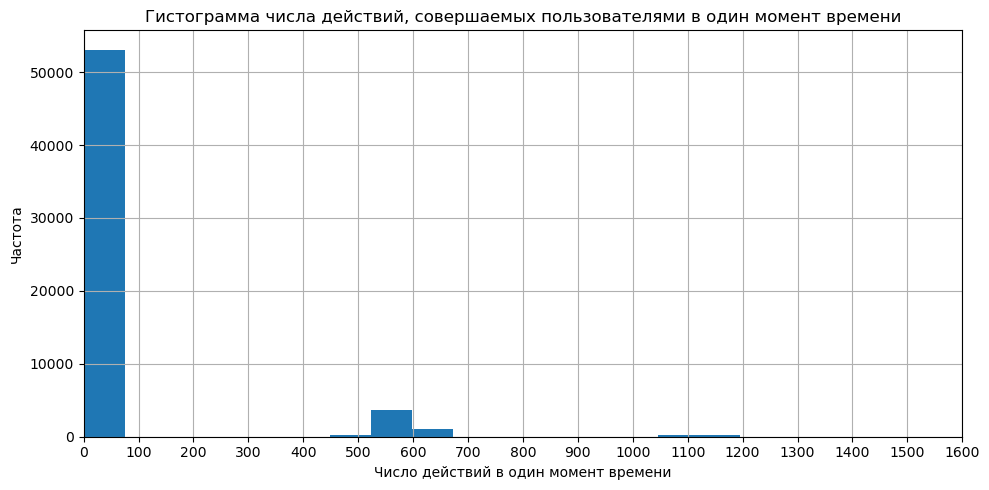

In [57]:
plt.figure(figsize=(10, 5))

plt.hist(df_count_timestamp['action_count'], bins=30)  

plt.title('Гистограмма числа действий, совершаемых пользователями в один момент времени')
plt.xlabel('Число действий в один момент времени')
plt.xlim(0, 1600)
plt.ylabel('Частота')
plt.gca().xaxis.set_major_locator(MultipleLocator(100))
plt.grid(True)
plt.tight_layout()
plt.show()

### Процент фордовых пользователей от общего числа

In [58]:
fraud = df_actions[df_actions['action_count']>100].sort_values(['action_count'], ascending = False)

In [59]:
# Уникальные пользватели
procent_fraud = (fraud.user_id.nunique() / df_actions.user_id.nunique())*100
procent_fraud

0.9580849583482203

In [61]:
## Удаляем фордовых пользователей из первоначадбных данных и соxраняем
df_clean.shape

(4228781, 7)

In [62]:
df_without_fraud = df_clean[~df_clean['user_id'].isin(fraud['user_id'])].reset_index(drop=True)
df_without_fraud.shape

(979805, 7)

In [63]:
df_fraud = df_clean[df_clean['user_id'].isin(fraud['user_id'])].reset_index(drop=True)
df_fraud.shape

(3248976, 7)

In [64]:
df_without_fraud.to_csv('data without fraud .csv', index=False)
df_fraud.to_csv('fraud .csv', index=False)

In [ ]:
df_fraud.to_csv('data fraud.csv', index=False)  
df_fraud.shape